# Abstract Retrieval

This notebook contains:
- BM25 (with Pyserini and Rank_BM25);
- BERT and T5 refined to Abstract Retrieval;
- Abstract-Level Metrics.

In [2]:
pip install protobuf==3.20.*

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -r pygaggle/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 45.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 46.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 MB 4.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

### Imports and Global Variables

In [1]:
import os
import copy
import torch
import random
import json
import jsonlines
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

#from nltk import tokenize
from torch.optim import Adam
from tqdm.notebook import tqdm
from rank_bm25 import BM25Okapi
from torch.utils.data import Dataset, DataLoader
from pyserini.search.lucene import LuceneSearcher
from sklearn.metrics import recall_score, accuracy_score, precision_score
from transformers import BertTokenizerFast, BertForSequenceClassification

#import pygaggle
from pygaggle.pygaggle.rerank.base import Query, Text, hits_to_texts
from pygaggle.pygaggle.rerank.transformer import MonoT5, MonoBERT

2022-11-30 14:46:19.416195: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-30 14:46:21.407732: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-30 14:46:21.408738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-30 14:46:21.409820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-30 14:46:21.409841: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:1


In [3]:
params = {
    'batch_size': 16,
    'optimizer': 'Adam',
    'learning_rate': 1e-5,
    'epochs': 1,
    'version': 'base',
    'model': 'bert',
    'early_stopping': None,
    'seed': 42,
    'max_length': 512,
    'evaluate_interval': 100,
    'accumulate_grad_batches': 4
}

### Read Json

In [4]:
def read_json(path):
    docs = []
    with jsonlines.open(path) as file:
        for line in file.iter():
            docs.append(line)
            
    return docs

corpus = read_json('data/corpus.jsonl')
train_json = read_json('data/claims_train.jsonl')
valid_json = read_json('data/claims_dev.jsonl')
test_json  = read_json('data/claims_test.jsonl')

### Metrics

In [5]:
def recall_abstract(true, preds, _id_):
    '''
        Calculate Recall for Document Retrieval
            Recall = No. of relevant documents retrieved / No. of total relevant documents
    
        Parameters
        ----------
        true : List
            List of documets returned from any search engine
        
        preds: Set
            List of relevant id documents
        
        _id_: str
            Key of the id
    '''
    count = 0.0
    for doc in preds:
        if str(doc[_id_]) in true:
            count += 1
    
    if count > len(true): count = len(true)

    return count / len(true)

def precision_abstract(true, preds, _id_):
    '''
        Calculate Precision for Document Retrieval
            Precision = No. of relevant documents retrieved / No. of total documents retrieved
    
        Parameters
        ----------
        true : List
            List of documets returned from any search engine
        
        preds: Set
            List of relevant id documents
        
        _id_: str
            Key of the id
    '''
    count = 0.0
    for doc in preds:
        if str(doc[_id_]) in true:
            count += 1
    
    if count > len(true): count = len(true)
        
    return count / len(doc)

def f1_score_abstract(recall, precision):
    '''
        Calculate F1 Score for Document Retrieval
            F-Score = 2 * Precision * Recall / Precision + Recall
    
        Parameters
        ----------
        recall : Float
        
        precision: Float
    '''
    
    return (2 * precision * recall) / (precision + recall)

### RankBM25

In [9]:
def corpusTokenizer(corpus):
    '''
        Tokenize the entire corpus
        
        Parameters
        ----------
        corpus: Json
            All corpus available (corpus.jsonl)
    '''
    
    tokenized_corpus = []
    for doc in corpus:
        abstract = [item.split(' ') for item in doc['abstract']]
        abstract = [item for sublist in abstract for item in sublist]

        tokenized_corpus.append(abstract)

    return tokenized_corpus

def claimTokenizer(dataset):
    '''
        Tokenize one query
        
        Parameters
        ----------
        dataset: Json
            One query of a dataset (E.g. fist element of train.jsonl)
    '''
    return dataset['claim'].split(' ')

def RankBM25(claim, tokenized_corpus, corpus, top_k=30):
    '''
        Apply the BM25 in only one query        
    '''
    bm25 = BM25Okapi(tokenized_corpus)
    results = bm25.get_top_n(claim, tokenized_corpus, n=top_k)
    return adjust_results(results, corpus)

def adjust_results(results, corpus):
    '''
        Adjust the bm25 result
    '''
    docs = []
   
    for sentence in results:
        sentence = ' '.join(sentence)
        
        for doc in corpus:
            sample = ' '.join(doc['abstract'])
            if sample == sentence:
                docs.append(doc)
    return docs

In [10]:
tokenized_corpus = corpusTokenizer(corpus)

sample = train_json[109]
tokenized_query = claimTokenizer(sample)

## ----- Query Example ----- ##
print(f'Sample: {sample}')
print(f'Tokenized Sample: {tokenized_query}')

docs = RankBM25(tokenized_query, tokenized_corpus, corpus, top_k=2)
docs

Sample: {'id': 181, 'claim': 'Blocking the interaction between TDP-43 and respiratory complex I proteins ND3 and ND6 prevents TDP-43-induced neuronal loss.', 'evidence': {'16966326': [{'sentences': [5], 'label': 'SUPPORT'}]}, 'cited_doc_ids': [16966326]}
Tokenized Sample: ['Blocking', 'the', 'interaction', 'between', 'TDP-43', 'and', 'respiratory', 'complex', 'I', 'proteins', 'ND3', 'and', 'ND6', 'prevents', 'TDP-43-induced', 'neuronal', 'loss.']


[{'doc_id': 16966326,
  'title': 'The Inhibition of TDP-43 Mitochondrial Localization Blocks Its Neuronal Toxicity',
  'abstract': ['Genetic mutations in TAR DNA-binding protein 43 (TARDBP, also known as TDP-43) cause amyotrophic lateral sclerosis (ALS), and an increase in the presence of TDP-43 (encoded by TARDBP) in the cytoplasm is a prominent histopathological feature of degenerating neurons in various neurodegenerative diseases.',
   'However, the molecular mechanisms by which TDP-43 contributes to ALS pathophysiology remain elusive.',
   'Here we have found that TDP-43 accumulates in the mitochondria of neurons in subjects with ALS or frontotemporal dementia (FTD).',
   'Disease-associated mutations increase TDP-43 mitochondrial localization.',
   'In mitochondria, wild-type (WT) and mutant TDP-43 preferentially bind mitochondria-transcribed messenger RNAs (mRNAs) encoding respiratory complex I subunits ND3 and ND6, impair their expression and specifically cause complex I disasse

In [11]:
top_k  = [1, 2, 3, 5, 10, 25, 50, 100]
rank_BM25_precision = []
rank_BM25_recall    = []
rank_BM25_f1_score  = []

tokenized_corpus = corpusTokenizer(corpus)

for t in top_k:
    recall    = 0.0
    precision = 0.0
    data_len = 0
    
    for sample in valid_json:
        claim    = claimTokenizer(sample)
        id_label = list(sample['evidence'].keys())
        
        if len(id_label) < 1: continue
        data_len += 1
        
        docs  = RankBM25(claim, tokenized_corpus, corpus, top_k=t)
        
        precision += precision_abstract(id_label, docs, 'doc_id')
        recall    += recall_abstract(id_label, docs, 'doc_id')
    
    precision /= data_len
    recall    /= data_len
    f_score   = f1_score_abstract(recall, precision)
    
    rank_BM25_precision.append(precision)
    rank_BM25_recall.append(recall)
    rank_BM25_f1_score.append(f_score)
    
    print(f'Top_k: {t} --- Precision: {precision} --- Recall: {recall} --- F1 Score: {f_score}')

Top_k: 1 --- Precision: 0.1422872340425532 --- Recall: 0.5527482269503546 --- F1 Score: 0.22631655720798957
Top_k: 2 --- Precision: 0.16888297872340424 --- Recall: 0.6529255319148937 --- F1 Score: 0.2683545066446326
Top_k: 3 --- Precision: 0.17952127659574468 --- Recall: 0.6879432624113474 --- F1 Score: 0.28473890779417044
Top_k: 5 --- Precision: 0.19547872340425532 --- Recall: 0.7477836879432623 --- F1 Score: 0.3099366601343785
Top_k: 10 --- Precision: 0.21409574468085107 --- Recall: 0.8036347517730497 --- F1 Score: 0.33811462117280755
Top_k: 25 --- Precision: 0.23138297872340424 --- Recall: 0.8639184397163121 --- F1 Score: 0.3650064148376486
Top_k: 50 --- Precision: 0.2393617021276596 --- Recall: 0.8838652482269505 --- F1 Score: 0.37670657777628513
Top_k: 100 --- Precision: 0.24601063829787234 --- Recall: 0.9064716312056738 --- F1 Score: 0.3869936579378068


### Pyserini

In [ ]:
def separate_corpus(corpus):
    for idx, sample in enumerate(corpus):
        with jsonlines.open(f'pyserini/doc_{idx}.jsonl', mode='w') as writer:
            doc = {}
            doc['id'] = sample['doc_id']
            doc['contents'] = ' '.join(sample['abstract'])
            writer.write(doc)

In [ ]:
!python -m pyserini.index.lucene \
  --collection JsonCollection \
  --input pyserini \
  --index scifact_index \
  --generator DefaultLuceneDocumentGenerator \
  --threads 1 \
  --storeRaw

In [6]:
def pyserini_search(claim, top_k, return_hits=False):
    docs = []
    searcher = LuceneSearcher('scifact_index')
    hits = searcher.search(claim, k=top_k)

    for i in range(len(hits)):
        docs.append(json.loads(hits[i].raw))
     
    if return_hits: return hits
    
    return docs

In [13]:
top_k  = [1, 2, 3, 5, 10, 25, 50, 100]
pyserini_precision = []
pyserini_recall    = []
pyserini_f1_score  = []

for t in top_k:
    recall    = 0.0
    precision = 0.0
    data_len = 0
    
    for sample in valid_json:
        claim   = sample['claim']
        id_label = list(sample['evidence'].keys())
        
        if len(id_label) < 1: continue
        data_len += 1
        
        docs  = pyserini_search(claim, t)
        
        precision += precision_abstract(id_label, docs, 'id')
        recall    += recall_abstract(id_label, docs, 'id')
    
    precision /= data_len
    recall    /= data_len
    f_score   = f1_score_abstract(recall, precision)
    
    pyserini_precision.append(precision)
    pyserini_recall.append(recall)
    pyserini_f1_score.append(f_score)
    
    print(f'Top_k: {t} --- Precision: {precision} --- Recall: {recall} --- F1 Score: {f_score}')

Top_k: 1 --- Precision: 0.35904255319148937 --- Recall: 0.7052304964539008 --- F1 Score: 0.4758323216390335
Top_k: 2 --- Precision: 0.4175531914893617 --- Recall: 0.8085106382978723 --- F1 Score: 0.5506992200119998
Top_k: 3 --- Precision: 0.4441489361702128 --- Recall: 0.8497340425531915 --- F1 Score: 0.5833734228422733
Top_k: 5 --- Precision: 0.47074468085106386 --- Recall: 0.8847517730496455 --- F1 Score: 0.6145234682660062
Top_k: 10 --- Precision: 0.5 --- Recall: 0.924822695035461 --- F1 Score: 0.649079143852663
Top_k: 25 --- Precision: 0.5159574468085106 --- Recall: 0.9484929078014184 --- F1 Score: 0.6683490191178952
Top_k: 50 --- Precision: 0.5212765957446809 --- Recall: 0.950886524822695 --- F1 Score: 0.6733966958879257
Top_k: 100 --- Precision: 0.5345744680851063 --- Recall: 0.9643617021276596 --- F1 Score: 0.6878520302613895


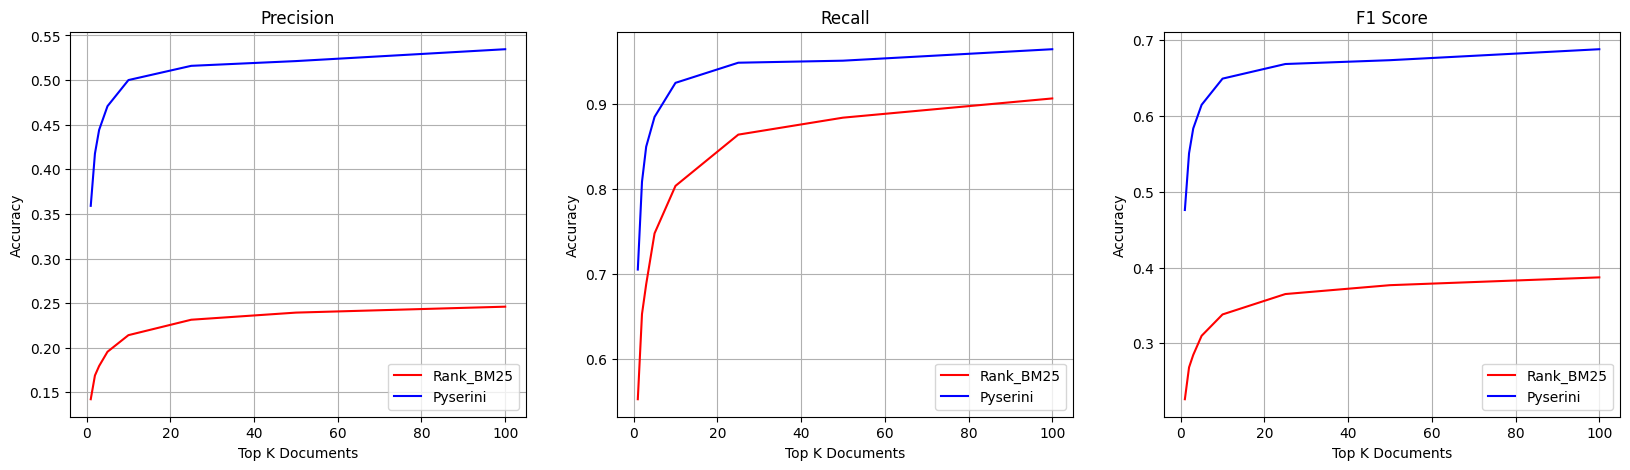

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].plot(top_k, rank_BM25_precision, '-r', label='Rank_BM25')
axes[0].plot(top_k, pyserini_precision, '-b', label='Pyserini')
axes[0].set_xlabel('Top K Documents'); axes[0].set_ylabel('Accuracy');
axes[0].set_title('Precision');
axes[0].grid(); axes[0].legend()

axes[1].plot(top_k, rank_BM25_recall, '-r', label='Rank_BM25')
axes[1].plot(top_k, pyserini_recall, '-b', label='Pyserini')
axes[1].set_xlabel('Top K Documents'); axes[1].set_ylabel('Accuracy');
axes[1].set_title('Recall');
axes[1].grid(); axes[1].legend()

axes[2].plot(top_k, rank_BM25_f1_score, '-r', label='Rank_BM25')
axes[2].plot(top_k, pyserini_f1_score, '-b', label='Pyserini')
axes[2].set_xlabel('Top K Documents'); axes[2].set_ylabel('Accuracy');
axes[2].set_title('F1 Score');
axes[2].grid(); axes[2].legend()

plt.show()

### monoBERT

In [9]:
top_k  = [3, 5]
bert_precision = []
bert_recall    = []
bert_f1_score  = []

reranker =  MonoBERT()

for t in top_k:
    recall    = 0.0
    precision = 0.0
    data_len = 0
    
    for sample in valid_json:
        claim   = sample['claim']
        id_label = list(sample['evidence'].keys())
        
        if len(id_label) < 1: continue
        data_len += 1
        
        hits  = pyserini_search(claim, top_k=100, return_hits=True)
        query = Query(claim)
        texts = hits_to_texts(hits)
        reranked = reranker.rerank(query, texts)
        
        docs = []
        for i in range(0, t):
            docs.append({'id': reranked[i].metadata['docid']})
    
        precision += precision_abstract(id_label, docs, 'id')
        recall    += recall_abstract(id_label, docs, 'id')
    
    precision /= data_len
    recall    /= data_len
    f_score   = f1_score_abstract(recall, precision)
    
    bert_precision.append(precision)
    bert_recall.append(recall)
    bert_f1_score.append(f_score)
    
    print(f'Top_k: {t} --- Precision: {precision} --- Recall: {recall} --- F1 Score: {f_score}')

Top_k: 3 --- Precision: 0.9468085106382979 --- Recall: 0.8840425531914893 --- F1 Score: 0.9143496482747536
Top_k: 5 --- Precision: 0.9946808510638298 --- Recall: 0.9196808510638298 --- F1 Score: 0.9557116929643577


### monoT5

In [10]:
top_k  = [3, 5]
T5_precision = []
T5_recall    = []
T5_f1_score  = []

reranker =  MonoT5()

for t in top_k:
    recall    = 0.0
    precision = 0.0
    data_len = 0
    
    for sample in valid_json:
        claim   = sample['claim']
        id_label = list(sample['evidence'].keys())
        
        if len(id_label) < 1: continue
        data_len += 1
        
        hits  = pyserini_search(claim, top_k=100, return_hits=True)
        query = Query(claim)
        texts = hits_to_texts(hits)
        reranked = reranker.rerank(query, texts)
        
        docs = []
        for i in range(0, t):
            docs.append({'id': reranked[i].metadata['docid']})
    
        precision += precision_abstract(id_label, docs, 'id')
        recall    += recall_abstract(id_label, docs, 'id')
    
    precision /= data_len
    recall    /= data_len
    f_score   = f1_score_abstract(recall, precision)
    
    T5_precision.append(precision)
    T5_recall.append(recall)
    T5_f1_score.append(f_score)
    
    print(f'Top_k: {t} --- Precision: {precision} --- Recall: {recall} --- F1 Score: {f_score}')

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Top_k: 3 --- Precision: 0.9574468085106383 --- Recall: 0.8933510638297871 --- F1 Score: 0.9242890730815445
Top_k: 5 --- Precision: 1.0159574468085106 --- Recall: 0.9289893617021276 --- F1 Score: 0.9705290200197259
